<h1>Lab Three: Extending Logistic Regression</h1>
<b>By Michael Watts, Maya Muralidhar, Nora Potenti, and Adam Ashcraft </b>

# 1.0 Business Understanding

This dataset is from the Free Music Archive, a collection of legally available audio files.  The numerical data is made up of features extracted from a musical analysis python package called librosa that quantifies some of the characteristics of an mp3 and also includes statistics such as mean, skew, and kurtosis.  The dataset also includes unique codes for genres of music.  We will use these features to determine what the genre of a piece is given the librosa feature extraction.  This classification would prove useful for a music streaming application such as Spotify that would want to integrate new music into its platform quickly, especially if the defined genre in the audio file's metadata doesn't matches one of the genres defined in the application's database.  It would also help with the application's recommendation system; by broadly defining the main genre categories, users could receive recommendations that are audially similar.  For this use case, the model would be deployed to a production.To measure our success, we will compare our results to the International Society for Music Information Retrieval’s Music Information Retrieval Evaluation eXchange (MIREX) 2017 competition winning algorithm LPNKK1, which has an accuracy of approximately 77%. Our algorithm is considered a success if it can outperform this academic algorithm’s genre classification success rate.
<hr>
Data Set Source: https://github.com/mdeff/fma <br>
MIREX Competition Results: http://www.music-ir.org/nema_out/mirex2017/results/act/mixed_report/summary.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pickle
import warnings
from sklearn.metrics import accuracy_score

In [2]:
feature_df = pd.read_csv("data/features.csv", skiprows=range(1,4))
feature_df.rename(columns={'feature':'track_id'}, inplace=True)
genre_df = pd.read_csv("data/genres.csv")
track_df = pd.read_csv("data/tracks.csv", skiprows=[0,2])
track_df.rename(columns={'Unnamed: 0':'track_id'}, inplace=True)
feature_df.head()

,track_id,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,...,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [3]:
genre_df.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [4]:
track_df.columns

Index(['track_id', 'comments', 'date_created', 'date_released', 'engineer',
       'favorites', 'id', 'information', 'listens', 'producer', 'tags',
       'title', 'tracks', 'type', 'active_year_begin', 'active_year_end',
       'associated_labels', 'bio', 'comments.1', 'date_created.1',
       'favorites.1', 'id.1', 'latitude', 'location', 'longitude', 'members',
       'name', 'related_projects', 'tags.1', 'website', 'wikipedia_page',
       'split', 'subset', 'bit_rate', 'comments.2', 'composer',
       'date_created.2', 'date_recorded', 'duration', 'favorites.2',
       'genre_top', 'genres', 'genres_all', 'information.1', 'interest',
       'language_code', 'license', 'listens.1', 'lyricist', 'number',
       'publisher', 'tags.2', 'title.1'],
      dtype='object')

There are several options for picking out a genre label: genre_top and genres seem to be good contenders.  Let's look at a sample of these two columns.

In [5]:
track_df[['genre_top', 'genres']].head()

,genre_top,genres
0,Hip-Hop,[21]
1,Hip-Hop,[21]
2,Hip-Hop,[21]
3,Pop,[10]
4,NaN,"[76, 103]"


genre_top is categorical and has missing values for some tracks.  There are no missing values in the genres column, but its datatype is a list, which would mean we'd have to figure out how to pick a label.  Let's try a different approach using the genre dataframe.

In [6]:
top_ten_genres = genre_df.sort_values(by='#tracks', ascending=False)[:10]
top_ten_genres

,genre_id,#tracks,parent,title,top_level
31,38,38154,0,Experimental,38
14,15,34413,0,Electronic,15
11,12,32923,0,Rock,12
162,1235,14938,0,Instrumental,1235
9,10,13845,0,Pop,10
16,17,12706,0,Folk,17
22,25,9261,12,Punk,12
0,1,8693,38,Avant-Garde,38
20,21,8389,0,Hip-Hop,21
27,32,7268,38,Noise,38


We'll only look at the top ten genres listed and, if the track's top genre is in this list, include that track in our reduced dataframe.

In [7]:
track_df = track_df[track_df['genre_top'].isin(top_ten_genres['title'].values)]
track_df['genre_top'].value_counts()

Rock            14182
Experimental    10608
Electronic       9372
Hip-Hop          3552
Folk             2803
Pop              2332
Instrumental     2079
Name: genre_top, dtype: int64

In [8]:
feature_df = feature_df.set_index('track_id').join(track_df[['track_id', 'genre_top']].set_index('track_id'))
feature_df.dropna(how='any', axis=0, inplace=True)
feature_df.head()

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,...,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6,genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,Hip-Hop
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,Hip-Hop
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,Hip-Hop
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,Pop
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,Hip-Hop


With our label determined, let's prepare the data for our model.

In [9]:
label_mapping = dict(zip(feature_df['genre_top'].unique(), range(0,10)))
y = feature_df['genre_top'].map(label_mapping, na_action='ignore').values
X = feature_df.drop(columns=['genre_top'])

There are a lot of numerical columns in the feature_df, so let's use PCA to reduce the dimensionality.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X)
sum(pca.explained_variance_ratio_)

0.962243056182637

It only takes 5 components to achieve 96% explained variance, most likely because the columns are various statistical methods on the same set of values.  Now to split the training and test data.

In [11]:
from sklearn.model_selection import train_test_split
# I'm adding a random_state so that the results of our shuffle don't change on different runs
# of the program
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(len(X_train))
print(len(X_test))

35942
8986


Doing an 80/20 train/test split is appropriate for our dataset because the data points aren't related to each other in time.  Shuffling the dataset is especially necessary because the data includes multiple tracks from the same album that are sequentially listed.

Now let’s pickle this data to ensure we are always get the same data from our split.


In [ ]:
pickle.dump(X_train, open( 'pickledData/X_train.p', 'wb' ))
pickle.dump(X_test, open( 'pickledData/X_test.p', 'wb' ))
pickle.dump(y_train, open( 'pickledData/y_train.p', 'wb' ))
pickle.dump(y_test, open( 'pickledData/y_test.p', 'wb' ))

In [13]:
from sklearn.preprocessing import StandardScaler
X_train = pickle.load(open( 'pickledData/X_train.p', 'rb' ))
X_test = pickle.load(open( 'pickledData/X_test.p', 'rb' ))
y_train = pickle.load(open( 'pickledData/y_train.p', 'rb' ))
y_test = pickle.load(open( 'pickledData/y_test.p', 'rb' ))


scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train)
X_test_scl = scl.transform(X_test)

<h1> 2.0 Modeling </h1>

<h2> 2.1 One-Versus-All Logistic Regression Classifier</h2>


We will begin by making a binary logistic regression class for steepest descent, stochastic and newton method logistic regressions. The classes will each accept an eta for step size and a number of iterations for which the regression will run. The user will be able to pass a keyword on the parameter reg into the class to determine which regularization method he wants to use on the data, “L1”, “L2”, “Both”, "None". It will start with "None" by default. We can make these classes based on the templetes we established in class


<h3> Binary Steepest Descent </h3>

In [2]:
from scipy.special import expit
from scipy.optimize import fmin_bfgs
class BinaryLogisticRegressionBase: #base class, never does anything just inherit from it
    # private:
    def __init__(self, eta, iterations=20, reg='None', C=0.001): #eta how big a step do I take #iterations how many steps
        self.eta = eta
        self.iters = iterations
        self.reg = reg
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self): #what you get when you call a string
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term, add 1s column to add bias 
    
    # public:
    def predict_proba(self,X,add_bias=True): #probabilities of each class what is the probability that a class of this instance = 1
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1 w transpose x
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y): #SLOW
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference how much you update the x value
       #if you y value is very different than predict_proba value, you can add another weight to determine how much this will effect the gradient. rarer classes get a higher weight 
       #assign the weights by class
        #use it to be more senstive to certin classes
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        #[:,np.newaxis] makes this into a column vector 
        return gradient.reshape(self.w_.shape)

class RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        
        
        # but keep other keywords
        super().__init__(C=self.C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization (to all except bias term)
        
        if(self.reg == 'L2'): #detect regularization
            gradient[1:] += -2 * self.w_[1:] * self.C
        if(self.reg == 'L1'):
            gradient[1:] += -1 * np.sign(self.w_[1:]) * self.C
        if(self.reg == 'Both'):
            gradient[1:] += (-2 * self.w_[1:] * self.C) + (-1 * np.sign(self.w_[1:]) * self.C)
            
        return gradient
    

<h3> Binary Stochastic Gradient Descent </h3>

In [3]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if(self.reg == 'L2'): #detect regularization
            gradient[1:] += -2 * self.w_[1:] * self.C
        if(self.reg == 'L1'):
            gradient[1:] += -1 * np.sign(self.w_[1:]) * self.C
        if(self.reg == 'Both'):
            gradient[1:] += (-2 * self.w_[1:] * self.C) + (-1 * np.sign(self.w_[1:]) * self.C)
        
        return gradient

<h3> Binary Newton's method (BFGS) </h3>

In [4]:
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function_L2(w,X,y,C): #optimized for L2
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))
    @staticmethod
    def objective_function_L1(w,X,y,C): #optimized for L1
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(np.absolute(w)) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))
    @staticmethod
    def objective_function_Both(w,X,y,C): #optimized for L1 and L2
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) + C*sum(np.absolute(w)) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))
    @staticmethod
    def objective_function_None(w,X,y,C): #no regularization
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0]))  #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient_No_Reg(w,X,y,C): #no regularization
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        return -gradient
    
    @staticmethod
    def objective_gradient_L1_Reg(w,X,y,C): #L1 regularization
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        
        gradient[1:] += -1 * np.sign(w[1:]) * C
        return -gradient
    
    @staticmethod
    def objective_gradient_L2_Reg(w,X,y,C): #L2 regularization
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    @staticmethod
    def objective_gradient_Both_Reg(w,X,y,C): #L1 and L2 regularization
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += (-2 * w[1:] * C) + (-1 * np.sign(w[1:]) * C)
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
       
        num_samples, num_features = Xb.shape
        if(self.reg == 'None'):
            self.w_ = fmin_bfgs(self.objective_function_None, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient_No_Reg, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        if(self.reg == 'L1'):
            self.w_ = fmin_bfgs(self.objective_function_L1, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient_L1_Reg, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        if(self.reg == 'L2'):
            self.w_ = fmin_bfgs(self.objective_function_L2, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient_L2_Reg, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        if(self.reg == 'Both'):
            self.w_ = fmin_bfgs(self.objective_function_Both, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient_Both_Reg, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        
        self.w_ = self.w_.reshape((num_features,1))
  

<h3> Multiclass Steepest Descent </h3>

In [5]:
class LogisticRegression:
    def __init__(self, eta, iterations=20, reg = "None"):
        self.eta = eta
        self.iters = iterations
        self.reg = reg
        
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,self.iters,self.reg)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
class RegularizedLogisticRegression(LogisticRegression):
    def __init__(self, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C

        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class

            blr = RegularizedBinaryLogisticRegression(eta=self.eta,
                                                      iterations=self.iters,
                                                      C=self.C, reg=self.reg,)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

<h3> Multiclass Stochastic Gradient Descent </h3>

In [6]:
class MultiClassStochasticLogisticRegression():
    def __init__(self, eta, iterations=20, C=0.0,reg = "None"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg = reg

       
    
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            SLR = StochasticLogisticRegression(eta=self.eta, reg = self.reg,
                                                      iterations=self.iters)
            SLR.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(SLR)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
    
    def predict_proba(self,X):
        probs = []
        for SLR in self.classifiers_:
            probs.append(SLR.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

<h3> Multiclass Binary Newton's method (BFGS) </h3>

In [7]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, reg = "None"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.reg = reg
        
        
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BFGSBinaryLogisticRegression(eta = self.eta,iterations = self.iters,reg = self.reg, C=self.C)
            hblr.fit(X=X,y=y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    

Now that we have created multiclass classes for each of our methods, we can create one logistic regression class which takes in as parameters, the eta, the number of iterations, the c value, the regularization technique to use, and the method to use. It will take the method as the last parameter as will have the options of “Steep” for steepest descent, “Stochastic” for stochastic gradient descent, and “Newton” for Newton’s method. From here the class will construct the appropriate object and use it to fit and predict the data accordingly.  
 


In [8]:
class GeneralLogisticRegression:
    def __init__(self, eta, iterations=100, C=0.0001, reg = "None", method="Steep"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.reg = reg
        if method == "Steep":
            self.LRObj = RegularizedLogisticRegression(C=self.C, eta = self.eta, iterations=self.iters, reg = self.reg)
        if method == "Stochastic":
            self.LRObj = MultiClassStochasticLogisticRegression(C=self.C, eta = self.eta, iterations=self.iters, reg = self.reg)
        if method == "Newton":
            self.LRObj = MultiClassLogisticRegression(C=self.C, eta = self.eta, iterations=self.iters, reg = self.reg)
            
    def fit(self,X,y):
        self.LRObj.fit(X,y)
        
    def predict(self, X):
        return self.LRObj.predict(X)

Now that we have our multi variable general logistic regression class, let’s run some test to find out which model and C-value will give us optimal results. We will set out eta value to .1, apply both L2 regularizations across our data, run 100 iterations, and vary the C value to see how it changes our accuracy. We will start with a C value of .001 and increase this value by .001 over 10 iterations. We will train our equation on the train data then run it against the test data.

In [68]:

warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train)
X_test_scl = scl.transform(X_test)
def C_Vary(methodType):
    accuracy = []
    C_Value = .001
    for _ in range(0,10):
        a = GeneralLogisticRegression(eta=.1, C = C_Value, method=methodType, reg="L2")
        a.fit(X_train_scl, y_train)
        yhat = a.predict(X_test_scl)
        accuracy.append(accuracy_score(y_test,yhat))
        C_Value = C_Value +.001
    return accuracy

Stochastic_Accuracy = C_Vary("Stochastic")
Steep_Accuracy = C_Vary("Steep")
Newton_Accuracy = C_Vary("Newton")


In [69]:
pickle.dump(Stochastic_Accuracy, open( 'pickledData/Stochastic_Accuracy.p', 'wb' ))
pickle.dump(Steep_Accuracy, open( 'pickledData/Steep_Accuracy.p', 'wb' ))
pickle.dump(Newton_Accuracy, open( 'pickledData/Newton_Accuracy.p', 'wb' ))


In [9]:
Stochastic_Accuracy = pickle.load(open( 'pickledData/Stochastic_Accuracy.p', 'rb' ))
Steep_Accuracy = pickle.load(open( 'pickledData/Steep_Accuracy.p', 'rb' ))
Newton_Accuracy = pickle.load(open( 'pickledData/Newton_Accuracy.p', 'rb' ))


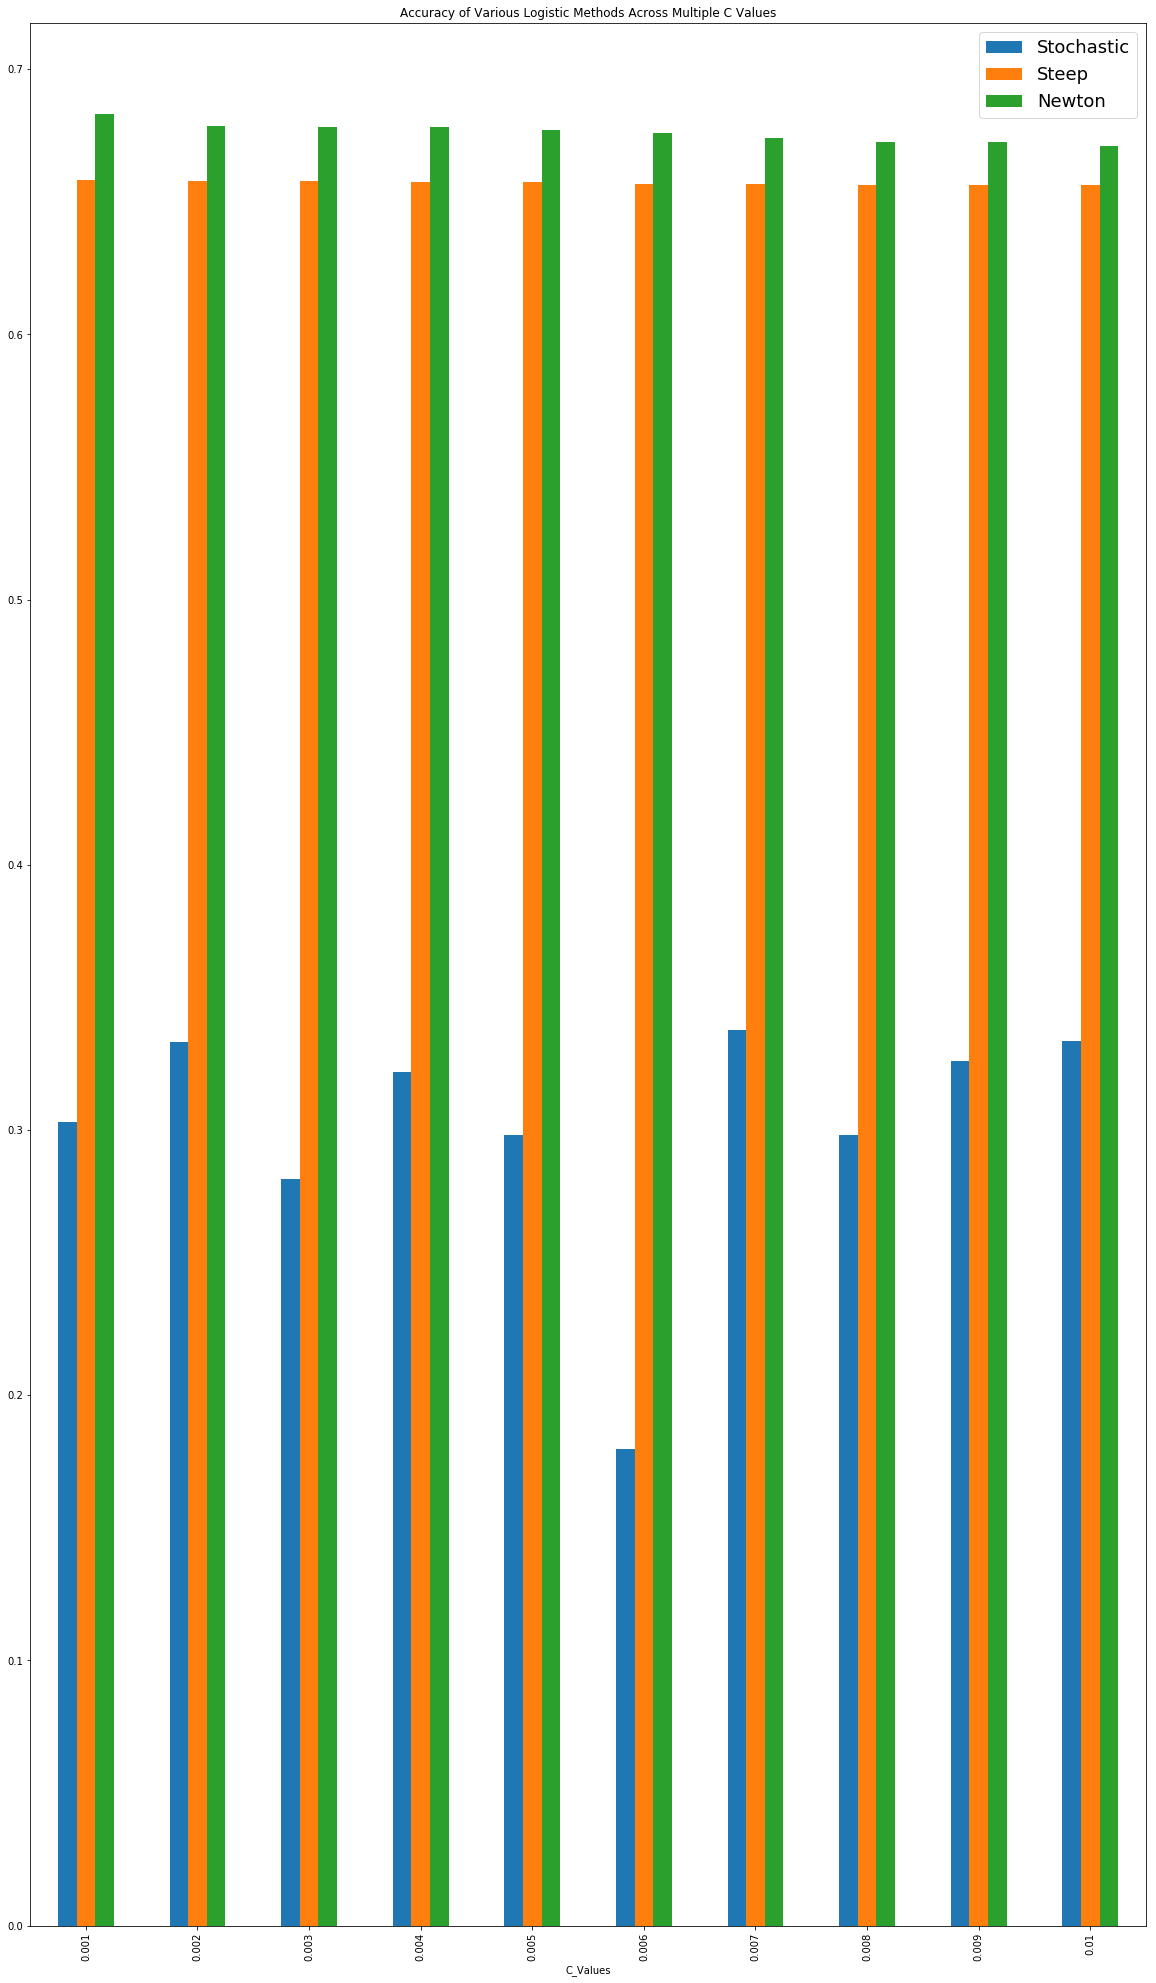

In [71]:
C_Values = [.001,.002,.003,.004,.005,.006,.007,.008,.009,.010]
converter = pd.Series(Stochastic_Accuracy)
df = pd.DataFrame()
df['Stochastic'] = converter.values

converter = pd.Series(Steep_Accuracy)
df['Steep'] = converter.values

converter = pd.Series(Newton_Accuracy)
df['Newton'] = converter.values

converter = pd.Series(C_Values)
df['C_Values'] = converter.values
fig1 = df.plot(kind='bar', x='C_Values', legend=True, title='Accuracy of Various Logistic Methods Across Multiple C Values',figsize=(20,35))
fig1.legend(prop={'size': 18})

After the results of our 10 trials, we can see that the Steep and Newton methods tend to work better than the Stochastic method consistently for our data. Both the Steep and Newton had the highest accuracy when ran with a Cost Value of .001. However all of this analysis exists on the caveat that additional C values may prove the value used for Cost is not very important, as we do a bigger and bigger grid search across more and more C values.



Now let’s run the scikit-learn’s Newton regression under the same set of parameters and see how our equation compares. We will run each equation 10 times, measuring the speed and accuracy of each run.

In [16]:
import time
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
sci_speed = []
sci_accuracy = []
our_speed =[]
our_accuracy = []

for _ in range(50):
    #scikit data crunching
    start = time.time()
    lr_sk = LogisticRegression(solver='lbfgs',C = .001)
    lr_sk.fit(X_train, y_train) 
    sci_hat = lr_sk.predict(X_test)
    sci_acc = accuracy_score(y_test,sci_hat)
    end = time.time()
    sci_time = start-end
    sci_speed.append(sci_time)
    sci_accuracy.append(sci_acc)
    #our data crunching
    start = time.time()
    a = GeneralLogisticRegression(eta=.1, C = .001, method='Newton', reg="L2")
    a.fit(X_train_scl, y_train)
    yhat = a.predict(X_test_scl)
    our_acc = accuracy_score(y_test,yhat)
    end = time.time()
    our_time = start-end
    our_speed.append(our_time)
    our_accuracy.append(our_acc)

In [17]:
pickle.dump(sci_speed, open( 'pickledData/sci_speed.p', 'wb' ))
pickle.dump(sci_accuracy, open( 'pickledData/sci_accuracy.p', 'wb' ))
pickle.dump(our_speed, open( 'pickledData/our_speed.p', 'wb' ))
pickle.dump(our_accuracy, open( 'pickledData/our_accuracy.p', 'wb' ))

In [18]:
sci_speed = pickle.load(open( 'pickledData/sci_speed.p', 'rb' ))
sci_accuracy = pickle.load(open( 'pickledData/sci_accuracy.p', 'rb' ))
our_speed = pickle.load(open( 'pickledData/our_speed.p', 'rb' ))
our_accuracy = pickle.load(open( 'pickledData/our_accuracy.p', 'rb' ))

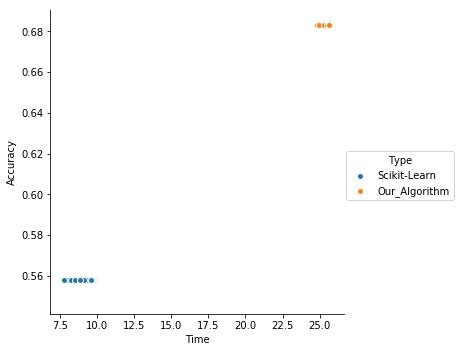

In [19]:
Sci_df = pd.DataFrame()
converter = pd.Series(sci_speed)
Sci_df['Time'] = converter.values
Sci_df['Time'] = Sci_df['Time'] * -1
converter = pd.Series(sci_accuracy)
Sci_df['Accuracy'] = converter.values
Sci_df['Type'] = 'Scikit-Learn'

Our_df = pd.DataFrame()
converter = pd.Series(our_speed)
Our_df['Time'] = converter.values
Our_df['Time'] = Our_df['Time'] * -1
converter = pd.Series(our_accuracy)
Our_df['Accuracy'] = converter.values
Our_df['Type'] = 'Our_Algorithm'
frames = [Sci_df,Our_df]
df = pd.concat(frames)
groups = df.groupby('Type')
#fig1 = df.plot(kind='scatter', x='Time',y='Accuracy', legend=True, title='Accuracy of Various Logistic Methods Across Multiple C Values')
# fig1.legend(prop={'size': 18})
# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group.Time, x='Time', y = 'Accuracy', group.Accuracy, marker='o', linestyle='', ms=12, label=name)
# ax.legend()
# plt.show()
sns.pairplot(y_vars=["Accuracy"], x_vars=["Time"], data=df, hue="Type", size=5)

Both algorithms tend to have consistent overall performance in accuracy.Our Newton’s method model runs at a similar but lower accuracy to the scikit-learn model but does it in approximately 40% of the time. Their accuracy tends to be approximately 14% higher than our algorithm. However our model runs in the range of 7.5-1.0 seconds and the scikit-learn model runs in the 25.0-27.0 seconds range. 




# Deployment

As we have seen from our previous trials, the Newton’s method tends to run the most accurately. Our model tends to run with an accuracy of approximately 56% while scikit-learn boast an approximate accuracy of 70%. However, neither of these models can compete with the LPNKK1 model from MIREX which boast an accuracy score of 77%.. For a platform based on searching for music such as Spotify, the accuracy of an algorithm is ultimately the most important factor. If a song is mis-categorized it cannot be found and played by those interested in it, and is instead found by those who are not. This leads to less plays and less money for the artist overall. In conclusion, Spotify should deploy an LPNKK1 algorithm from MIREX instead of our or scikit-learn’s Newton Logistic Regression for the categorization of their content. 


